# Poisson Processes

Think Bayes, Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [67]:
# Get utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

In [3]:
from utils import set_pyplot_params
set_pyplot_params()

This chapter introduces the [Poisson process](https://en.wikipedia.org/wiki/Poisson_point_process), which is a model used to describe events that occur at random intervals.
As an example of a Poisson process, we'll model goal-scoring in soccer, which is American English for the game everyone else calls "football".
We'll use goals scored in a game to estimate the parameter of a Poisson process; then we'll use the posterior distribution to make predictions.

And we'll solve The World Cup Problem.

## The World Cup Problem

In the 2018 FIFA World Cup final, France defeated Croatia 4 goals to 2.  Based on this outcome:

1. How confident should we be that France is the better team?

2. If the same teams played again, what is the chance France would win again?

To answer these questions, we have to make some modeling decisions.

* First, I'll assume that for any team against another team there is some unknown goal-scoring rate, measured in goals per game, which I'll denote with the Python variable `lam` or the Greek letter $\lambda$, pronounced "lambda".

* Second, I'll assume that a goal is equally likely during any minute of a game.  So, in a 90 minute game, the probability of scoring during any minute is $\lambda/90$.

* Third, I'll assume that a team never scores twice during the same minute.

Of course, none of these assumptions is completely true in the real world, but I think they are reasonable simplifications.
As George Box said, "All models are wrong; some are useful."
(https://en.wikipedia.org/wiki/All_models_are_wrong).

In this case, the model is useful because if these assumptions are 
true, at least roughly, the number of goals scored in a game follows a Poisson distribution, at least roughly.





## 世界杯问题

2018年FIFA世界杯决赛，法国4比2击败克罗地亚。基于这样的结果：

1. 我们应该对法国是一支更好的球队有多大的信心？

2.如果同样的球队再次上场，法国队再次获胜的机会有多大？

为了回答这些问题，我们必须做出一些建模决策。

* 首先，我假设任何一支球队对阵另一支球队都有一些未知的进球率，以每场比赛的进球数来衡量，我将用 Python 变量“lam”或希腊字母 $\lambda$ 来表示，发音为“λ”。

* 其次，我假设在比赛的任何一分钟内进球的可能性都是一样的。因此，在一场 90 分钟的比赛中，任何一分钟的得分概率都是 $\lambda/90$。

* 第三，我假设一支球队在同一分钟内永远不会得分两次。

当然，这些假设在现实世界中都不是完全正确的，但我认为它们是合理的简化。
正如 George Box 所说，“所有模型都是错误的；有些是有用的。”
（https://en.wikipedia.org/wiki/All_models_are_wrong）。

在这种情况下，该模型很有用，因为如果这些假设是
确实，至少粗略地说，一场比赛的进球数遵循泊松分布，至少大致如此。

>注： 泊松这里λ表示在每个区间内时间发生的平均次数，e是自然常数，k能够从0到n取值。，而k就是事件发生k次

## The Poisson Distribution

If the number of goals scored in a game follows a [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) with a goal-scoring rate, $\lambda$, the probability of scoring $k$ goals is

$$\lambda^k \exp(-\lambda) ~/~ k!$$

for any non-negative value of $k$.

SciPy provides a `poisson` object that represents a Poisson distribution.
We can create one with $\lambda=1.4$ like this:


## 泊松分布

如果一场比赛的进球数遵循 [泊松分布](https://en.wikipedia.org/wiki/Poisson_distribution)，其中进球率为 $\lambda$，则进球数目为 $k$是

$$\lambda^k \exp(-\lambda) ~/~ k!$$

对于 $k$ 的任何非负值。

SciPy 提供了一个表示泊松分布的“泊松”对象。
我们可以像这样用 $\lambda=1.4$ 创建一个：

In [2]:
from scipy.stats import poisson

lam = 1.4
dist = poisson(lam)
type(dist)

scipy.stats._distn_infrastructure.rv_discrete_frozen

In [39]:
dist

The result is an object that represents a "frozen" random variable and provides `pmf`, which evaluates the probability mass function of the Poisson distribution.

结果是一个表示“冻结”随机变量并提供“pmf”的对象，该对象评估泊松分布的概率质量函数

In [41]:
k = 4
dist.pmf(k)

0.039471954028253146

This result implies that if the average goal-scoring rate is 1.4 goals per game, the probability of scoring 4 goals in a game is about 4%.

We'll use the following function to make a `Pmf` that represents a Poisson distribution.

这个结果意味着，如果平均每场进球率为 1.4 球，那么一场比赛进 4 球的概率约为 4%。

我们将使用以下函数来创建一个表示泊松分布的“Pmf”。

In [42]:
from empiricaldist import Pmf

def make_poisson_pmf(lam, qs):
    """Make a Pmf of a Poisson distribution."""
    ps = poisson(lam).pmf(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

`make_poisson_pmf` takes as parameters the goal-scoring rate, `lam`, and an array of quantities, `qs`, where it should evaluate the Poisson PMF.  It returns a `Pmf` object.

For example, here's the distribution of goals scored for `lam=1.4`, computed for values of `k` from 0 to 9.

`make_poisson_pmf` 将目标得分率`lam` 和数量数组`qs` 作为参数，它应该评估泊松 PMF。它返回一个“Pmf”对象。

例如，这里是 `lam=1.4` 的进球分布，计算 `k` 的值从 0 到 9。

In [44]:
import numpy as np

lam = 1.4
goals = np.arange(10)
pmf_goals = make_poisson_pmf(lam, goals)
pmf_goals

,probs
0,0.246598
1,0.345237
2,0.241666
3,0.112777
4,0.039472
5,0.011052
6,0.002579
7,0.000516
8,0.000090
9,0.000014


And here's what it looks like.

In [45]:
from utils import decorate

def decorate_goals(title=''):
    decorate(xlabel='Number of goals',
        ylabel='PMF',
        title=title)

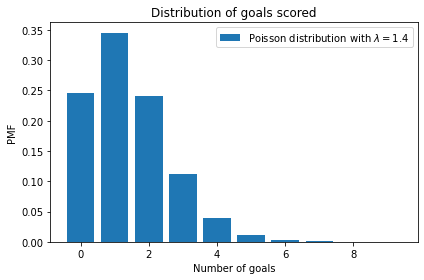

In [46]:
pmf_goals.bar(label=r'Poisson distribution with $\lambda=1.4$')

decorate_goals('Distribution of goals scored')

The most likely outcomes are 0, 1, and 2; higher values are possible but increasingly unlikely.
Values above 7 are negligible.
This distribution shows that if we know the goal scoring rate, we can predict the number of goals.

Now let's turn it around: given a number of goals, what can we say about the goal-scoring rate?

To answer that, we need to think about the prior distribution of `lam`, which represents the range of possible values and their probabilities before we see the score.

最可能的结果是 0、1 和 2；更高的值是可能的，但越来越不可能。
高于 7 的值可以忽略不计。
这个分布表明，如果我们知道进球率，我们就可以预测进球数。

现在让我们转过头来：给定多个目标，我们能说什么关于进球得分率？

要回答这个问题，我们需要考虑 lam 的先验分布，它表示可能值的范围及其概率，然后才能看到分数。

## The Gamma Distribution

If you have ever seen a soccer game, you have some information about `lam`.  In most games, teams score a few goals each.  In rare cases, a team might score more than 5 goals, but they almost never score more than 10.

Using [data from previous World Cups](https://www.statista.com/statistics/269031/goals-scored-per-game-at-the-fifa-world-cup-since-1930/), I estimate that each team scores about 1.4 goals per game, on average.  So I'll set the mean of `lam` to be 1.4.

For a good team against a bad one, we expect `lam` to be higher; for a bad team against a good one, we expect it to be lower.

To model the distribution of goal-scoring rates, I'll use a [gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution), which I chose because:

1. The goal scoring rate is continuous and non-negative, and the gamma distribution is appropriate for this kind of quantity.

2. The gamma distribution has only one parameter, `alpha`, which is the mean.  So it's easy to construct a gamma distribution with the mean we want.

3. As we'll see, the shape of the gamma distribution is a reasonable choice, given what we know about soccer.

And there's one more reason, which I will reveal in <<_ConjugatePriors>>.

SciPy provides `gamma`, which creates an object that represents a gamma distribution.
And the `gamma` object provides provides `pdf`, which evaluates the  **probability density function** (PDF) of the gamma distribution.

Here's how we use it.

为了模拟进球得分率的分布，我将使用 [gamma 分布](https://en.wikipedia.org/wiki/Gamma_distribution)，我之所以选择它是因为：

1.进球率是连续的非负的，伽马分布适合这种数量。

2. gamma 分布只有一个参数，`alpha`，即均值。所以很容易构造一个我们想要的均值的伽马分布。

3. 正如我们将看到的，考虑到我们对足球的了解，伽马分布的形状是一个合理的选择。

还有一个原因，我将在 <<_ConjugatePriors>> 中揭示。

SciPy 提供了 `gamma`，它创建了一个表示 gamma 分布的对象。
并且 `gamma` 对象提供了 `pdf`，它评估了 gamma 分布的**概率密度函数** (PDF)。

以下是我们如何使用它。

In [48]:
from scipy.stats import gamma

alpha = 1.4
qs = np.linspace(0, 10, 101)
ps = gamma(alpha).pdf(qs)
ps

array([0.00000000e+00, 4.05992285e-01, 4.84730481e-01, 5.15830938e-01,
       5.23664860e-01, 5.18069457e-01, 5.04232738e-01, 4.85266496e-01,
       4.63177696e-01, 4.39318203e-01, 4.14622386e-01, 3.89744839e-01,
       3.65145833e-01, 3.41147147e-01, 3.17970016e-01, 2.95761751e-01,
       2.74614870e-01, 2.54581111e-01, 2.35681863e-01, 2.17916017e-01,
       2.01265929e-01, 1.85701980e-01, 1.71186077e-01, 1.57674352e-01,
       1.45119231e-01, 1.33471035e-01, 1.22679194e-01, 1.12693180e-01,
       1.03463196e-01, 9.49407002e-02, 8.70787698e-02, 7.98323681e-02,
       7.31585144e-02, 6.70163876e-02, 6.13673765e-02, 5.61750878e-02,
       5.14053232e-02, 4.70260320e-02, 4.30072463e-02, 3.93210034e-02,
       3.59412599e-02, 3.28437997e-02, 3.00061393e-02, 2.74074316e-02,
       2.50283707e-02, 2.28510976e-02, 2.08591086e-02, 1.90371664e-02,
       1.73712156e-02, 1.58483006e-02, 1.44564887e-02, 1.31847968e-02,
       1.20231222e-02, 1.09621773e-02, 9.99342898e-03, 9.10904094e-03,
      

The parameter, `alpha`, is the mean of the distribution.
The `qs` are possible values of `lam` between 0 and 10.
The `ps` are **probability densities**, which we can think of as unnormalized probabilities.

To normalize them, we can put them in a `Pmf` and call `normalize`:

参数“alpha”是分布的平均值。
`qs` 是 `lam` 的可能值，介于 0 和 10 之间。
`ps` 是**概率密度**，我们可以将其视为非标准化概率。

为了规范化它们，我们可以将它们放在 `Pmf` 中并调用 `normalize`：

In [49]:
from empiricaldist import Pmf

prior = Pmf(ps, qs)
prior.normalize()

9.889360237140304

The result is a discrete approximation of a gamma distribution.
Here's what it looks like.

In [50]:
def decorate_rate(title=''):
    decorate(xlabel='Goal scoring rate (lam)',
        ylabel='PMF',
        title=title)

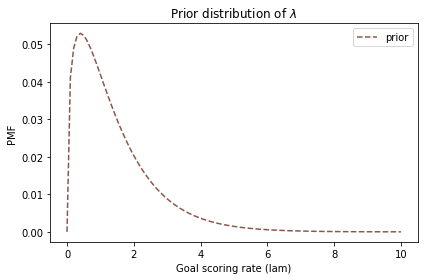

In [11]:
prior.plot(ls='--', label='prior', color='C5')
decorate_rate(r'Prior distribution of $\lambda$')

  This distribution represents our prior knowledge about goal scoring: `lam` is usually less than 2, occasionally as high as 6, and seldom higher than that.

  这个分布代表了我们关于进球得分的先验知识：“lam”通常小于 2，偶尔高达 6，很少高于。

And we can confirm that the mean is about 1.4.

我们可以确认平均值约为 1.4。

In [51]:
prior.mean()

1.4140818156118382

As usual, reasonable people could disagree about the details of the prior, but this is good enough to get started.  Let's do an update.

像往常一样，理性的人可能会不同意先前的细节，但这已经足够开始了。让我们做一个更新

## The Update

Suppose you are given the goal-scoring rate, $\lambda$, and asked to compute the probability of scoring a number of goals, $k$.  That is precisely the question we answered by computing the Poisson PMF.

For example, if $\lambda$ is 1.4, the probability of scoring 4 goals in a game is:

## 更新

假设给定进球率$\lambda$，并要求你计算进球数$k$。这正是我们通过计算泊松 PMF 回答的问题。

例如，如果 $\lambda$ 为 1.4，那么在一场比赛中进 4 个球的概率为：

In [12]:
lam = 1.4
k = 4
poisson(lam).pmf(4)

0.039471954028253146

Now suppose we are have an array of possible values for $\lambda$; we can compute the likelihood of the data for each hypothetical value of `lam`, like this:

现在假设我们有一个 $\lambda$ 的可能值数组；我们可以计算 `lam` 的每个假设值的数据的可能性，如下所示：

In [13]:
lams = prior.qs
k = 4
likelihood = poisson(lams).pmf(k)

And that's all we need to do the update.
To get the posterior distribution, we multiply the prior by the likelihoods we just computed and normalize the result.

The following function encapsulates these steps.

这就是我们进行更新所需的全部内容。
为了得到后验分布，我们将先验乘以我们刚刚计算的可能性并对结果进行归一化。

以下函数封装了这些步骤。

In [16]:
def update_poisson(pmf, data):
    """Update Pmf with a Poisson likelihood."""
    k = data
    lams = pmf.qs
    likelihood = poisson(lams).pmf(k)
    pmf *= likelihood
    pmf.normalize()

The first parameter is the prior; the second is the number of goals.

In the example, France scored 4 goals, so I'll make a copy of the prior and update it with the data.

第一个参数是先验；二是进球数。

在示例中，法国进了 4 个进球，因此我将复制之前的数据并使用数据对其进行更新。

In [17]:
france = prior.copy()
update_poisson(france, 4)

Here's what the posterior distribution looks like, along with the prior.

这是后验分布和先验分布的样子。

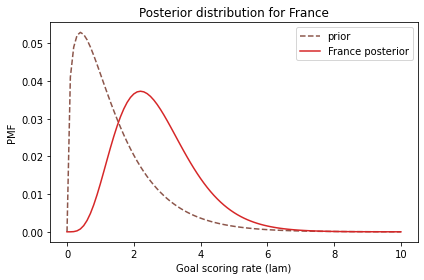

In [18]:
prior.plot(ls='--', label='prior', color='C5')
france.plot(label='France posterior', color='C3')

decorate_rate('Posterior distribution for France')

The data, `k=4`, makes us think higher values of `lam` are more likely and lower values are less likely.  So the posterior distribution is shifted to the right.

Let's do the same for Croatia:

`k=4` 的数据让我们认为 `lam` 的值较高的可能性更大，而较低的值不太可能。所以后验分布向右移动。

让我们为克罗地亚做同样的事情：

In [19]:
croatia = prior.copy()
update_poisson(croatia, 2)

And here are the results.

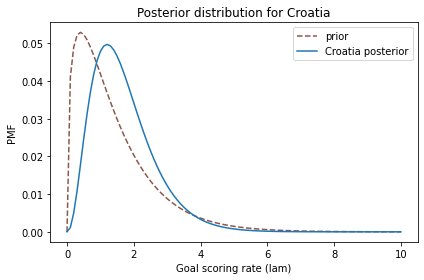

In [20]:
prior.plot(ls='--', label='prior', color='C5')
croatia.plot(label='Croatia posterior', color='C0')

decorate_rate('Posterior distribution for Croatia')

Here are the posterior means for these distributions.

In [21]:
print(croatia.mean(), france.mean())

1.699976586675523 2.699772393342308


The mean of the prior distribution is about 1.4.
After Croatia scores 2 goals, their posterior mean is 1.7, which is near the midpoint of the prior and the data.
Likewise after France scores 4 goals, their posterior mean is 2.7.

These results are typical of a Bayesian update: the location of the posterior distribution is a compromise between the prior and the data.

先验分布的平均值约为 1.4。
克罗地亚进2球后，他们的后验均值为1.7，接近先验和数据的中点。
同样，在法国进 4 球后，他们的后验均值为 2.7。

这些结果是典型的贝叶斯更新：后验分布的位置是先验和数据之间的折衷。

## Probability of Superiority

Now that we have a posterior distribution for each team, we can answer the first question: How confident should we be that France is the better team?

In the model, "better" means having a higher goal-scoring rate against the opponent.  We can use the posterior distributions to compute the probability that a random value drawn from France's distribution exceeds a value drawn from Croatia's.

One way to do that is to enumerate all pairs of values from the two distributions, adding up the total probability that one value exceeds the other.

## 优势概率

现在我们有了每支球队的后验分布，我们可以回答第一个问题：我们应该对法国是一支更好的球队有多大信心？

在模型中，“更好”意味着对对手有更高的进球率。我们可以使用后验分布来计算从法国分布中抽取的随机值超过从克罗地亚分布中抽取的值的概​​率。

一种方法是枚举两个分布中的所有值对，将一个值超过另一个的总概率相加。

In [22]:
def prob_gt(pmf1, pmf2):
    """Compute the probability of superiority."""
    total = 0
    for q1, p1 in pmf1.items():
        for q2, p2 in pmf2.items():
            if q1 > q2:
                total += p1 * p2
    return total

This is similar to the method we use in <<_Addends>> to compute the distribution of a sum.
Here's how we use it:

这类似于我们在 <<_Addends>> 中用于计算总和分布的方法。
以下是我们如何使用它：

In [23]:
prob_gt(france, croatia)

0.7499366290930157

`Pmf` provides a function that does the same thing.

`Pmf` 提供了一个做同样事情的函数。

In [24]:
Pmf.prob_gt(france, croatia)

0.7499366290930175

The results are slightly different because `Pmf.prob_gt` uses array operators rather than `for` loops.

Either way, the result is close to 75%.  So, on the basis of one game, we have moderate confidence that France is actually the better team.

Of course, we should remember that this result is based on the assumption that the goal-scoring rate is constant.
In reality, if a team is down by one goal, they might play more aggressively toward the end of the game, making them more likely to score, but also more likely to give up an additional goal.

As always, the results are only as good as the model.

结果略有不同，因为 `Pmf.prob_gt` 使用数组运算符而不是 `for` 循环。

无论哪种方式，结果都接近 75%。所以，在一场比赛的基础上，我们有适度的信心认为法国队实际上是更好的球队。

当然，我们应该记住，这个结果是基于进球率恒定的假设。
实际上，如果一支球队落后一球，他们可能会在比赛快结束时打得更激进，这使他们更有可能得分，但也更有可能放弃一个额外的进球。

与往常一样，结果仅与模型一样好。

## Predicting the Rematch

Now we can take on the second question: If the same teams played again, what is the chance Croatia would win?
To answer this question, we'll generate the "posterior predictive distribution", which is the number of goals we expect a team to score.

If we knew the goal scoring rate, `lam`, the distribution of goals would be a Poisson distribution with parameter `lam`.
Since we don't know `lam`, the distribution of goals is a mixture of a Poisson distributions with different values of `lam`.

First I'll generate a sequence of `Pmf` objects, one for each value of `lam`.

## 预测重赛

现在我们可以提出第二个问题：如果同样的球队再次比赛，克罗地亚获胜的机会有多大？
为了回答这个问题，我们将生成“后验预测分布”，即我们期望球队进球的数量。

如果我们知道进球率“lam”，那么进球的分布将是带有参数“lam”的泊松分布。
由于我们不知道“lam”，因此目标的分布是具有不同“lam”值的泊松分布的混合。

首先，我将生成一系列 `Pmf` 对象，每个 `lam` 值对应一个。

In [25]:
pmf_seq = [make_poisson_pmf(lam, goals) 
           for lam in prior.qs]

The following figure shows what these distributions look like for a few values of `lam`.
下图显示了一些 `lam` 值的分布情况。

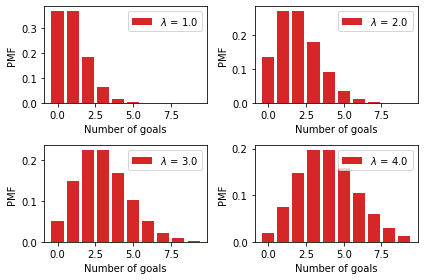

In [26]:
import matplotlib.pyplot as plt

for i, index in enumerate([10, 20, 30, 40]):
    plt.subplot(2, 2, i+1)
    lam = prior.qs[index]
    pmf = pmf_seq[index]
    pmf.bar(label=f'$\lambda$ = {lam}', color='C3')
    decorate_goals()

The predictive distribution is a mixture of these `Pmf` objects, weighted with the posterior probabilities.
We can use `make_mixture` from <<_GeneralMixtures>> to compute this mixture.

预测分布是这些“Pmf”对象的混合，用后验概率加权。
我们可以使用 <<_GeneralMixtures>> 中的 `make_mixture` 来计算这种混合。

In [ ]:
pmf_seq

In [27]:
from utils import make_mixture

pred_france = make_mixture(france, pmf_seq)

Here's the predictive distribution for the number of goals France would score in a rematch.

这是法国队在复赛中进球数的预测分布。

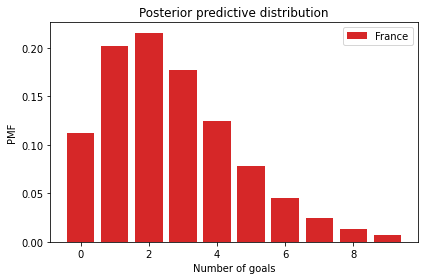

In [28]:
pred_france.bar(color='C3', label='France')
decorate_goals('Posterior predictive distribution')

This distribution represents two sources of uncertainty: we don't know the actual value of `lam`, and even if we did, we would not know the number of goals in the next game.

Here's the predictive distribution for Croatia.

这个分布代表了两个不确定性来源：我们不知道 lam 的实际值，即使我们知道了，我们也不知道下一场比赛的进球数。

这是克罗地亚的预测分布。

In [29]:
pred_croatia = make_mixture(croatia, pmf_seq)

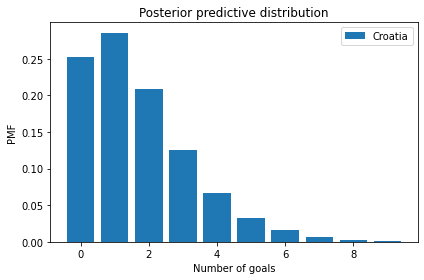

In [30]:
pred_croatia.bar(color='C0', label='Croatia')
decorate_goals('Posterior predictive distribution')

We can use these distributions to compute the probability that France wins, loses, or ties the rematch.

我们可以使用这些分布来计算法国获胜、失败或平局的概率。

In [31]:
win = Pmf.prob_gt(pred_france, pred_croatia)
win

0.5703522415934522

In [32]:
lose = Pmf.prob_lt(pred_france, pred_croatia)
lose

0.26443376257235884

In [33]:
tie = Pmf.prob_eq(pred_france, pred_croatia)
tie

0.16521399583418955

Assuming that France wins half of the ties, their chance of winning the rematch is about 65%.

假设法国赢得了一半的比赛，他们赢得复赛的机会约为65%。

In [34]:
win + tie/2

0.652959239510547

This is a bit lower than their probability of superiority, which is 75%. And that makes sense, because we are less certain about the outcome of a single game than we are about the goal-scoring rates.
Even if France is the better team, they might lose the game.

这略低于他们的优势概率，即 75%。这是有道理的，因为我们对单场比赛的结果的确定不如对进球率的确定。
即使法国队是更好的球队，他们也可能会输掉比赛。

## The Exponential Distribution

As an exercise at the end of this notebook, you'll have a chance to work on  the following variation on the World Cup Problem:

>In the 2014 FIFA World Cup, Germany played Brazil in a semifinal match. Germany scored after 11 minutes and again at the 23 minute mark. At that point in the match, how many goals would you expect Germany to score after 90 minutes? What was the probability that they would score 5 more goals (as, in fact, they did)?

In this version, notice that the data is not the number of goals in a fixed period of time, but the time between goals.

To compute the likelihood of data like this, we can take advantage of the theory of Poisson processes again.  If each team has a constant goal-scoring rate, we expect the time between goals to follow an [exponential distribution](https://en.wikipedia.org/wiki/Exponential_distribution).

If the goal-scoring rate is $\lambda$, the probability of seeing an interval between goals of $t$ is proportional to the PDF of the exponential distribution:

$$\lambda \exp(-\lambda t)$$

Because $t$ is a continuous quantity, the value of this expression is not a probability; it is a probability density.  However, it is proportional to the probability of the data, so we can use it as a likelihood in a Bayesian update.

SciPy provides `expon`, which creates an object that represents an exponential distribution.
However, it does not take `lam` as a parameter in the way you might expect, which makes it awkward to work with.
Since the PDF of the exponential distribution is so easy to evaluate, I'll use my own function.


## 指数分布

作为本笔记本末尾的练习，您将有机会处理以下关于世界杯问题的变体：

>2014年FIFA世界杯，德国在半决赛中对阵巴西。德国在第 11 分钟和第 23 分钟再次得分。在比赛的那个时刻，你希望德国队在 90 分钟后进多少球？他们再进 5 个球的概率是多少（事实上，他们确实做到了）？

在这个版本中，注意数据不是固定时间段内的进球数，而是进球之间的时间。

为了计算这样的数据的可能性，我们可以再次利用泊松过程理论。如果每支球队都有一个恒定的进球得分率，我们预计进球之间的时间遵循[指数分布]（https://en.wikipedia.org/wiki/Exponential_distribution）。

如果目标得分率为 $\lambda$，则看到 $t$ 目标之间的间隔的概率与指数分布的 PDF 成正比：

$$\lambda \exp(-\lambda t)$$

因为$t$是一个连续量，所以这个表达式的值不是概率；它是一个概率密度。但是，它与数据的概率成正比，因此我们可以将其用作贝叶斯更新中的可能性。

SciPy 提供了“expon”，它创建了一个表示指数分布的对象。
但是，它并没有像您期望的那样将 `lam` 作为参数，这使得使用起来很尴尬。
由于指数分布的 PDF 很容易评估，我将使用我自己的函数。

In [35]:
def expo_pdf(t, lam):
    """Compute the PDF of the exponential distribution."""
    return lam * np.exp(-lam * t)

To see what the exponential distribution looks like, let's assume again that `lam` is 1.4; we can compute the distribution of $t$ like this:

为了看看指数分布是什么样的，让我们再次假设 lam 是 1.4；我们可以像这样计算 $t$ 的分布：

In [36]:
lam = 1.4
qs = np.linspace(0, 4, 101)
ps = expo_pdf(qs, lam)
pmf_time = Pmf(ps, qs)
pmf_time.normalize()

25.616650745459093

And here's what it looks like:

In [37]:
def decorate_time(title=''):
    decorate(xlabel='Time between goals (games)',
             ylabel='PMF',
             title=title)

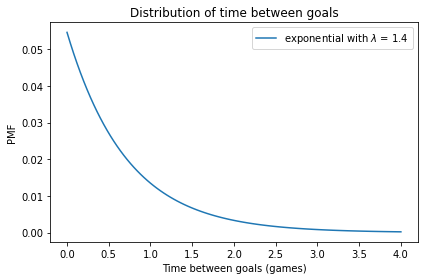

In [38]:
pmf_time.plot(label='exponential with $\lambda$ = 1.4')

decorate_time('Distribution of time between goals')

It is counterintuitive, but true, that the most likely time to score a goal is immediately.  After that, the probability of each successive interval is a little lower.

With a goal-scoring rate of 1.4, it is possible that a team will take more than one game to score a goal, but it is unlikely that they will take more than two games.

这是违反直觉的，但确实是，最有可能进球的时间是立即。之后，每个连续区间的概率都会低一点。

对于 1.4 的进球率，一支球队可能需要不止一场比赛才能进球，但他们不太可能需要超过两场比赛。

## Summary

This chapter introduces three new distributions, so it can be hard to keep them straight.
Let's review:

* If a system satisfies the assumptions of a Poisson model, the number of events in a period of time follows a Poisson distribution, which is a discrete distribution with integer quantities from 0 to infinity. In practice, we can usually ignore low-probability quantities above a finite limit.

* Also under the Poisson model, the interval between events follows an exponential distribution, which is a continuous distribution with quantities from 0 to infinity. Because it is continuous, it is described by a probability density function (PDF) rather than a probability mass function (PMF). But when we use an exponential distribution to compute the likelihood of the data, we can treat densities as unnormalized probabilities.

* The Poisson and exponential distributions are parameterized by an event rate, denoted $\lambda$ or `lam`.

* For the prior distribution of $\lambda$, I used a gamma distribution, which is a continuous distribution with quantities from 0 to infinity, but I approximated it with a discrete, bounded PMF. The gamma distribution has one parameter, denoted $\alpha$ or `alpha`, which is also its mean.

I chose the gamma distribution because the shape is consistent with our background knowledge about goal-scoring rates.
There are other distributions we could have used; however, we will see in <<_ConjugatePriors>> that the gamma distribution can be a particularly good choice.

But we have a few things to do before we get there, starting with these exercises.

## 概括

本章介绍了三个新的分布，因此很难保持直截了当。
让我们来复习：

* 如果一个系统满足泊松模型的假设，那么一段时间内的事件数量服从泊松分布，这是一个从 0 到无穷大的整数数量的离散分布。在实践中，我们通常可以忽略超出有限限制的低概率量。

* 同样在泊松模型下，事件之间的间隔遵循指数分布，这是一个数量从 0 到无穷大的连续分布。因为它是连续的，所以用概率密度函数 (PDF) 而不是概率质量函数 (PMF) 来描述。但是当我们使用指数分布来计算数据的可能性时，我们可以将密度视为非标准化概率。

* 泊松和指数分布由事件率参数化，表示为 $\lambda$ 或 `lam`。

* 对于 $\lambda$ 的先验分布，我使用了 gamma 分布，它是数量从 0 到无穷大的连续分布，但我用离散的有界 PMF 来近似它。伽马分布有一个参数，表示为 $\alpha$ 或 `alpha`，这也是它的均值。

我选择了伽马分布，因为它的形状与我们关于进球率的背景知识一致。
我们可以使用其他发行版；但是，我们将在 <<_ConjugatePriors>> 中看到 gamma 分布可能是一个特别好的选择。

但是在我们到达那里之前，我们还有一些事情要做，从这些练习开始。

## Exercises

**Exercise:** Let's finish the exercise we started:

>In the 2014 FIFA World Cup, Germany played Brazil in a semifinal match. Germany scored after 11 minutes and again at the 23 minute mark. At that point in the match, how many goals would you expect Germany to score after 90 minutes? What was the probability that they would score 5 more goals (as, in fact, they did)?

**练习：** 让我们完成我们开始的练习：

>2014年FIFA世界杯，德国在半决赛中对阵巴西。德国在第 11 分钟和第 23 分钟再次得分。在比赛的那个时刻，你希望德国队在 90 分钟后进多少球？他们再进 5 个球的概率是多少（事实上，他们确实做到了）？

Here are the steps I recommend:

1. Starting with the same gamma prior we used in the previous problem, compute the likelihood of scoring a goal after 11 minutes for each possible value of `lam`.  Don't forget to convert all times into games rather than minutes.

2. Compute the posterior distribution of `lam` for Germany after the first goal.

3. Compute the likelihood of scoring another goal after 12 more minutes and do another update.  Plot the prior, posterior after one goal, and posterior after two goals.

4. Compute the posterior predictive distribution of goals Germany might score during the remaining time in the game, `90-23` minutes.  Note: You will have to think about how to generate predicted goals for a fraction of a game.

5. Compute the probability of scoring 5 or more goals during the remaining time.

以下是我推荐的步骤：

1. 从我们在上一个问题中使用的相同 gamma 先验开始，计算每个可能的 `lam` 值在 11 分钟后进球的可能性。不要忘记将所有时间转换为游戏而不是分钟。

2. 计算第一个进球后德国的 `lam` 的后验分布。

3. 计算再过 12 分钟后再进一球的可能性，然后再做一次更新。在一个目标之后绘制先验图，在一个目标之后绘制后验图，在两个目标之后绘制后验图。

4. 计算德国在比赛剩余时间“90-23”分钟内可能进球的后验预测分布。注意：您将不得不考虑如何为比赛的一小部分生成预测目标。

5. 计算在剩余时间内进 5 个或更多球的概率。

In [40]:
# Solution goes here

In [41]:
# Solution goes here

In [42]:
# Solution goes here

In [43]:
# Solution goes here

In [44]:
# Solution goes here

In [45]:
# Solution goes here

In [46]:
# Solution goes here

In [47]:
# Solution goes here

In [48]:
# Solution goes here

**Exercise:** Returning to the first version of the World Cup Problem.  Suppose France and Croatia play a rematch.  What is the probability that France scores first?
**练习：** 回到第一个版本的世界杯问题。 假设法国和克罗地亚复赛。 法国首先得分的概率是多少？

Hint: Compute the posterior predictive distribution for the time until the first goal by making a mixture of exponential distributions.  You can use the following function to make a PMF that approximates an exponential distribution.

提示：通过混合指数分布来计算直到第一个目标的时间的后验预测分布。 您可以使用以下函数来制作近似指数分布的 PMF。

In [49]:
def make_expo_pmf(lam, high):
    """Make a PMF of an exponential distribution.
    
    lam: event rate
    high: upper bound on the interval `t`
    
    returns: Pmf of the interval between events
    """
    qs = np.linspace(0, high, 101)
    ps = expo_pdf(qs, lam)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

In [50]:
# Solution goes here

In [51]:
# Solution goes here

In [52]:
# Solution goes here

In [53]:
# Solution goes here

**Exercise:** In the 2010-11 National Hockey League (NHL) Finals, my beloved Boston
Bruins played a best-of-seven championship series against the despised
Vancouver Canucks.  Boston lost the first two games 0-1 and 2-3, then
won the next two games 8-1 and 4-0.  At this point in the series, what
is the probability that Boston will win the next game, and what is
their probability of winning the championship?

To choose a prior distribution, I got some statistics from
http://www.nhl.com, specifically the average goals per game
for each team in the 2010-11 season.  The distribution is well modeled by a gamma distribution with mean 2.8.

In what ways do you think the outcome of these games might violate the assumptions of the Poisson model?  How would these violations affect your predictions?

In [54]:
# Solution goes here

In [55]:
# Solution goes here

In [56]:
# Solution goes here

In [57]:
# Solution goes here

In [58]:
# Solution goes here

In [59]:
# Solution goes here

In [60]:
# Solution goes here

In [61]:
# Solution goes here

In [62]:
# Solution goes here

In [63]:
# Solution goes here

In [64]:
# Solution goes here

In [65]:
# Solution goes here